In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.width",200)
pd.set_option("display.float_format",lambda x:"%.2f" % x)

C:\Users\Ertuğrul\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [27]:
df=pd.read_excel("nlp/datasets/amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [28]:
df["Review"]=df["Review"].str.lower()
df["Review"]=df["Review"].str.replace("[^\w\s]"," ")
df["Review"]=df["Review"].str.replace("\d"," ")



In [29]:
import nltk
sw=stopwords.words("english")
df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"].head()

0                                                happy
1    good quality material however panels mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck can't believe quality material...
Name: Review, dtype: object

In [30]:
temp_df=pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]


df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in temp_df))
df["Review"].head()



0                                                happy
1    good quality material however panels mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck can't believe quality material...
Name: Review, dtype: object

In [31]:
nltk.download("wordnet")

df["Review"]=df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df["Review"].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ertuğrul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck can't believe quality material...
Name: Review, dtype: object

In [32]:
tf=df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns=["words","tf"]
tf.sort_values("tf",ascending=False)

,words,tf
71,curtain,1773.00
45,look,1459.00
133,love,1412.00
192,like,1033.00
30,great,721.00
...,...,...
5261,appeal.,1.00
5260,peacefulness,1.00
5259,sweep,1.00
5258,help.,1.00


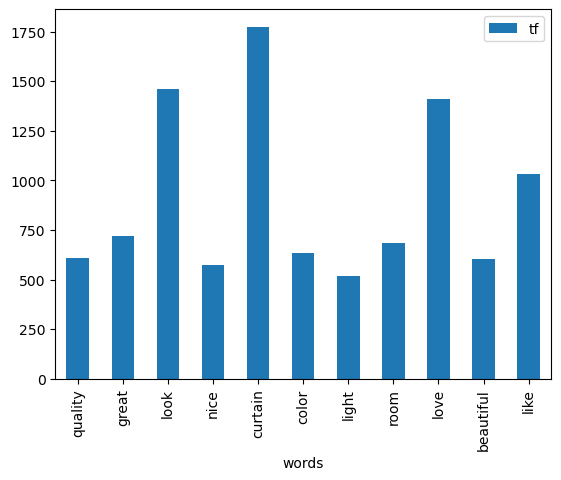

In [33]:
#Barplot

tf[tf["tf"]>500].plot.bar(x="words",y="tf")
plt.show()

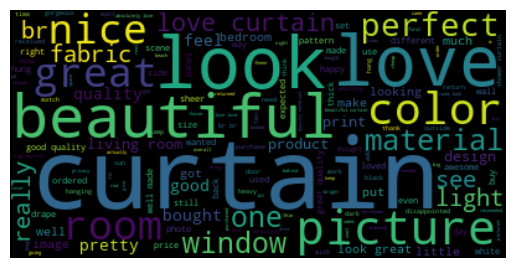

In [34]:
text = " ".join(i for i in df.Review)

wordcloud=WordCloud().generate(text)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [43]:
nltk.download("vader_lexicon")
sia=SentimentIntensityAnalyzer()
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ertuğrul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.93
8   0.00
9   0.71
Name: Review, dtype: float64

In [47]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentimental_label"]=df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentimental_label"]= LabelEncoder().fit_transform(df["sentimental_label"])

y=df["sentimental_label"]

X=df["Review"]

In [50]:
from sklearn.model_selection import train_test_split


train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["sentimental_label"],
                                                    random_state=42)


from sklearn.feature_extraction.text import TfidfVectorizer



tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))
print(cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean())


              precision    recall  f1-score   support

           0       0.31      0.97      0.47        72
           1       1.00      0.89      0.94      1331

    accuracy                           0.89      1403
   macro avg       0.66      0.93      0.71      1403
weighted avg       0.96      0.89      0.91      1403

0.8538891713268937


In [55]:
from sklearn.feature_extraction.text import CountVectorizer

random_review = pd.Series(df["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  curtain look awesome, son love them. completely wrinkle-free, complaining - stating facts. =) 
 Prediction: [1]


In [56]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
print(cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean())

0.8980732079308591
